In [1]:
import os, sys
sys.path.append(os.path.abspath("../../"))

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import dowhy
from dowhy import CausalModel
import dowhy.datasets, dowhy.plotter

## Load the data

In [7]:
df = pd.read_csv('data/data.csv')

In [8]:
causal_df = df.drop(['id', 'Unnamed: 32'], axis=1).copy()

In [9]:
d = {'B':0, 'M':1}
causal_df['diagnosis'] = causal_df['diagnosis'].map(d)

The target column is changed from a cateogrical value to a numerical value
by representing 'B' with 0 and 'M' with 1

## Split data

In [10]:
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(causal_df, random_state=20, test_size=.2)

In [11]:
train_df.shape

In [12]:
xs = train_df.iloc[:,2:].columns.tolist()

## Create Causal Model

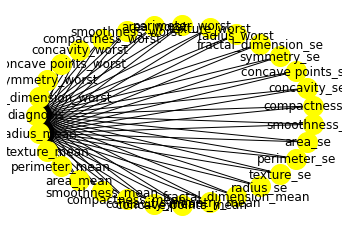

In [36]:
# Create a causal model from the data and given common causes.

model=CausalModel(
        data = train_df,
        treatment='diagnosis',
        outcome='radius_mean',
        common_causes=xs
        )
model.view_model(layout="dot")

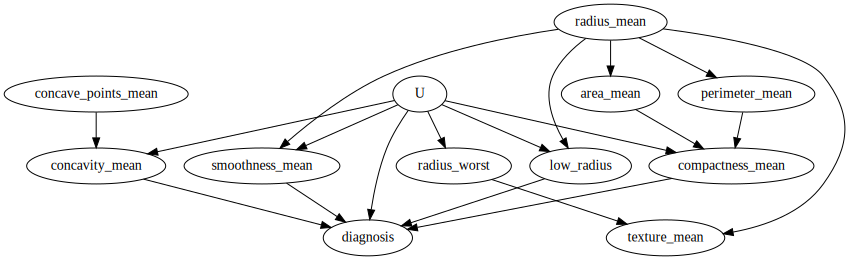

In [37]:
from causalgraphicalmodels import CausalGraphicalModel
causal = CausalGraphicalModel(
    nodes=['radius_mean','perimeter_mean','area_mean','smoothness_mean','compactness_mean','concavity_mean',
           'concave_points_mean','diagnosis','low_radius','texture_mean','radius_worst','U'],
    edges=[
        ("radius_mean", "perimeter_mean"), 
        ("radius_mean", "area_mean"),
        ("radius_mean", "texture_mean"),
        ("radius_mean","smoothness_mean"),
        ("radius_mean","low_radius"),
         ("radius_worst", "texture_mean"),
        ("area_mean","compactness_mean"),
        ("perimeter_mean","compactness_mean"),
        ("concave_points_mean","concavity_mean"),
        ("U","compactness_mean"),
        ("U","smoothness_mean"),
        ("U","concavity_mean"),
         ("U","radius_worst"),
        ("U","low_radius"),
        ("U","diagnosis"),
        ("low_radius","diagnosis"),
        ("smoothness_mean","diagnosis"),
        ("concavity_mean","diagnosis"),
        ("compactness_mean","diagnosis")
    ]
)
# draw return a graphviz `dot` object, which jupyter can render
causal.draw()

## Causal Effect

In [38]:
#Identify the causal effect
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                                        
────────────(Expectation(radius_mean|symmetry_se,concave points_worst,texture_
d[diagnosis]                                                                  

                                                                              
mean,smoothness_se,concavity_mean,compactness_mean,concavity_se,perimeter_wors
                                                                              

                                                                              
t,concave points_mean,perimeter_se,area_worst,smoothness_worst,fractal_dimensi
                                                                              

                                                                              
on_se,radius_se,smoothness_mean,texture_worst,concavity_worst,compactness_se,a
                                

## Estimate causal effect with linear regression

In [41]:
# Estimate the causal effect and compare it with Average Treatment Effect
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression", test_significance=True
)

print(estimate)

print("Causal Estimate is " + str(estimate.value))
data_1 = train_df[train_df["diagnosis"]==1]
data_0 = train_df[train_df["diagnosis"]==0]

print("ATE", np.mean(data_1["radius_mean"])- np.mean(data_0["radius_mean"]))

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                                        
────────────(Expectation(radius_mean|symmetry_se,concave points_worst,texture_
d[diagnosis]                                                                  

                                                                              
mean,smoothness_se,concavity_mean,compactness_mean,concavity_se,perimeter_wors
                                                                              

                                                                              
t,concave points_mean,perimeter_se,area_worst,smoothness_worst,fractal_dimensi
                                                                              

                                                                              
on_se,radius_se,smoothness_mean,texture_worst,concavity_worst,c

The mean value is relatively low, which means that there is no any meaningful relationship between
the features

## Refutation

In [42]:
refute_results=model.refute_estimate(identified_estimand, estimate,
        method_name="random_common_cause")
print(refute_results)

Refute: Add a Random Common Cause
Estimated effect:-0.02617928069619424
New effect:-0.02586494836169706



In [62]:
res_placebo=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute")
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:-0.026179280696220886
New effect:0.0010272587874021965
p value:0.46



In [63]:
res_subset=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter", subset_fraction=0.9)
print(res_subset)

Refute: Use a subset of data
Estimated effect:-0.026179280696220886
New effect:-0.02630367061375857
p value:0.48



The mean value from the above refutation is -0.0261. This leads to the ground truth that the causality 
from the all the features is very unclear.The features will be reduced to see what the new mean value 
will be.

## Reducing the features

In [43]:
causal_df

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,1,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,1,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,1,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,1,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [62]:
causal_df['low_radius'] = causal_df['radius_mean'].apply(lambda x: True if x < 18 else False)

In [64]:
train_features = {'diagnosis','radius','area','perimeter','compactness','smoothness','concave points','concavity'}
train_columns = [col for col in causal_df 
                      if any(feature in col for feature in train_features)]
train_columns

['diagnosis',
 'radius_mean',
 'perimeter_mean',
 'area_mean',
 'smoothness_mean',
 'compactness_mean',
 'concavity_mean',
 'concave points_mean',
 'radius_se',
 'perimeter_se',
 'area_se',
 'smoothness_se',
 'compactness_se',
 'concavity_se',
 'concave points_se',
 'radius_worst',
 'perimeter_worst',
 'area_worst',
 'smoothness_worst',
 'compactness_worst',
 'concavity_worst',
 'concave points_worst',
 'low_radius']

In [65]:
training = causal_df[train_columns]
training = training.drop(training.filter(regex = '_worst').columns,axis=1)
training = training.drop(training.filter(regex = '_se').columns,axis=1)
training.rename(columns={'concave points_mean':'concave_points_mean'},inplace=True)
training.head()

,diagnosis,radius_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,low_radius
0,1,17.99,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,True
1,1,20.57,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,False
2,1,19.69,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,False
3,1,11.42,77.58,386.1,0.14250,0.28390,0.2414,0.10520,True
4,1,20.29,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,False


In [50]:
causal_graph = """
digraph{
radius_mean;
perimeter_mean;
area_mean;
smoothness_mean;
compactness_mean;
concavity_mean;
concave_points_mean;
U[label="Unobserved Confounders"];
radius_mean -> perimeter_mean;radius_mean -> area_mean;radius_mean -> smoothness_mean;radius_mean->low_radius;area_mean->compactness_mean;
perimeter_mean->compactness_mean;concave_points_mean->concavity_mean;
U->compactness_mean;U->smoothness_mean;U->concavity_mean;U->low_radius;U->diagnosis;
compactness_mean->diagnosis;smoothness_mean->diagnosis;concavity_mean->diagnosis;low_radius->diagnosis;
}
"""

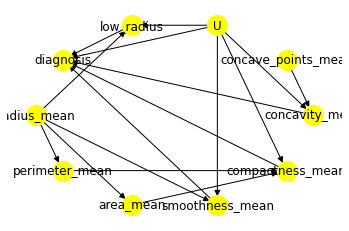

In [66]:
model= CausalModel(
        data = training,
        graph=causal_graph.replace("\n", " "),
        treatment='low_radius',
        outcome='diagnosis')
model.view_model()

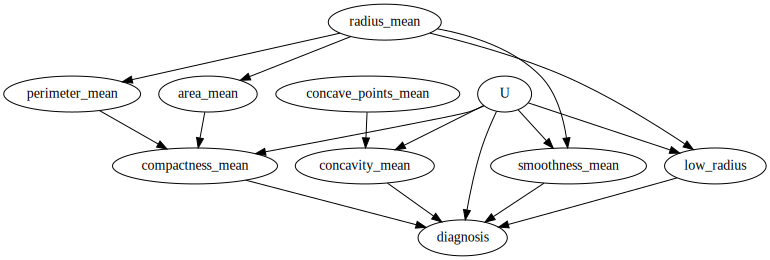

In [53]:
#area and perimeter functions of radius
from causalgraphicalmodels import CausalGraphicalModel
causal = CausalGraphicalModel(
    nodes=['radius_mean','perimeter_mean','area_mean','smoothness_mean','compactness_mean','concavity_mean',
           'concave_points_mean','diagnosis','low_radius','U'],
    edges=[
        ("radius_mean", "perimeter_mean"), 
        ("radius_mean", "area_mean"),
        ("radius_mean","smoothness_mean"),
        ("radius_mean","low_radius"),
        ("area_mean","compactness_mean"),
        ("perimeter_mean","compactness_mean"),
        ("concave_points_mean","concavity_mean"),
        ("U","compactness_mean"),
        ("U","smoothness_mean"),
        ("U","concavity_mean"),
        ("U","low_radius"),
        ("U","diagnosis"),
        ("low_radius","diagnosis"),
        ("smoothness_mean","diagnosis"),
        ("concavity_mean","diagnosis"),
        ("compactness_mean","diagnosis")
    ]
)
# draw return a graphviz `dot` object, which jupyter can render
causal.draw()

In [67]:
estimands = model.identify_effect()
print(estimands)

WARN: Do you want to continue by ignoring any unobserved confounders? (use proceed_when_unidentifiable=True to disable this prompt) [y/n] y
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                                                                       
─────────────(Expectation(diagnosis|smoothness_mean,concave_points_mean,concav
d[low_radius]                                                                 

                                                                
ity_mean,compactness_mean,perimeter_mean,area_mean,radius_mean))
                                                                
Estimand assumption 1, Unconfoundedness: If U→{low_radius} and U→diagnosis then P(diagnosis|low_radius,smoothness_mean,concave_points_mean,concavity_mean,compactness_mean,perimeter_mean,area_mean,radius_mean,U) = P(diagnosis|low_radius,smoothness_mean,concave_points_mean,concavity_mean,compactness_mean,perimeter_mean,area_mean,ra

In [68]:
#Causal Effect Estimation
#Method based on estimating the treatment assignment
estimate = model.estimate_effect(estimands,method_name = "backdoor.propensity_score_weighting")
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                                                                       
─────────────(Expectation(diagnosis|smoothness_mean,concave_points_mean,concav
d[low_radius]                                                                 

                                                                
ity_mean,compactness_mean,perimeter_mean,area_mean,radius_mean))
                                                                
Estimand assumption 1, Unconfoundedness: If U→{low_radius} and U→diagnosis then P(diagnosis|low_radius,smoothness_mean,concave_points_mean,concavity_mean,compactness_mean,perimeter_mean,area_mean,radius_mean,U) = P(diagnosis|low_radius,smoothness_mean,concave_points_mean,concavity_mean,compactness_mean,perimeter_mean,area_mean,radius_mean)

## Realized estimand
b: diagnosis~low_radius+smoothness_mean+concave_points_mean

C:\Users\daud\Anaconda3\Anaconda4\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\daud\Anaconda3\Anaconda4\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [58]:
# Estimate the causal effect and compare it with Average Treatment Effect
estimate = model.estimate_effect(estimands,
        method_name="backdoor.linear_regression", test_significance=True
)
print(estimate)
print("Causal Estimate is " + str(estimate.value))
data_1 = train_df[train_df["diagnosis"]==1]
data_0 = train_df[train_df["diagnosis"]==0]

print("ATE", np.mean(data_1["radius_mean"])- np.mean(data_0["radius_mean"]))

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                                                                       
─────────────(Expectation(diagnosis|smoothness_mean,concave_points_mean,concav
d[low_radius]                                                                 

                                                                
ity_mean,compactness_mean,perimeter_mean,area_mean,radius_mean))
                                                                
Estimand assumption 1, Unconfoundedness: If U→{low_radius} and U→diagnosis then P(diagnosis|low_radius,smoothness_mean,concave_points_mean,concavity_mean,compactness_mean,perimeter_mean,area_mean,radius_mean,U) = P(diagnosis|low_radius,smoothness_mean,concave_points_mean,concavity_mean,compactness_mean,perimeter_mean,area_mean,radius_mean)

## Realized estimand
b: diagnosis~low_radius+smoothness_mean+concave_points_mean

In [60]:
#Logistic regression estimate
import statsmodels.api as sm
causal_estimate = model.estimate_effect(estimands,
                                        method_name="backdoor.generalized_linear_model",
                                       confidence_intervals=False,
                                       test_significance=False,
                                        method_params = {
                                            'num_null_simulations':10,
                                            'num_simulations':10,
                                            'num_quantiles_to_discretize_cont_cols':10,
                                            'fit_method': "statsmodels",
                                            'glm_family': sm.families.Binomial(), # logistic regression
                                            'need_conditional_estimates':False
                                        },
                                       )
print(causal_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                                                                       
─────────────(Expectation(diagnosis|smoothness_mean,concave_points_mean,concav
d[low_radius]                                                                 

                                                                
ity_mean,compactness_mean,perimeter_mean,area_mean,radius_mean))
                                                                
Estimand assumption 1, Unconfoundedness: If U→{low_radius} and U→diagnosis then P(diagnosis|low_radius,smoothness_mean,concave_points_mean,concavity_mean,compactness_mean,perimeter_mean,area_mean,radius_mean,U) = P(diagnosis|low_radius,smoothness_mean,concave_points_mean,concavity_mean,compactness_mean,perimeter_mean,area_mean,radius_mean)

## Realized estimand
b: diagnosis~Sigmoid(low_radius+smoothness_mean+concave_poi

In [61]:
refute_train = model.refute_estimate(estimands,estimate, "random_common_cause")
print(refute_train)

Refute: Add a Random Common Cause
Estimated effect:-0.5077308392735328
New effect:-0.5094483072509882

